# 量子テレポーテーション

このノートでは量子テレポーテーションについて説明します。まず始めに、作成した量子回路を Qiskit に組み込まれているシミュレーターを使ってテストします。その後、その回路を実際の量子コンピューターで動かしてみます。

## 目次

1. [概要](#overview)    
2. [量子テレポーテーション・プロトコル](#how)       
3. [テレポーテーション・プロトコルのシミュレーション](#simulating)   
    3.1 [実際の量子コンピュータにおける結果の検査方法](#testing)   
    3.2 [状態ベクトル・シミュレーターを使った方法](#simulating-sv)     
    3.3 [QASM・シミュレーターを使った方法](#simulating-qs)    
4. [量子テレポーテーションを理解する](#understanding-qt)
5. [実際の量子コンピュータにおけるテレポーテーション](#real_qc)    
    5.1 [IBM ハードウェアと遅延測定](#deferred-measurement)    
    5.2 [実行](#executing)    
6. [参考文献](#references)


## 1. 概要 <a id='overview'></a>

アリスがボブに量子情報を送りたいとしましょう。これを具体的に、アリスがボブに状態
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$
を送りたい、と仮定します。その為にはまず、$\alpha$ と $\beta$ の情報をボブに渡す必要があります。

量子力学には、未知の量子状態の単純な複製を正確に作ることは出来ない、という定理が存在します。量子複製不可能定理（no-cloning theorem）として知られているものです。この定理ゆえ、アリスが単純に $\vert\psi\rangle$ の複製を生成してそれをボブに渡す、という事は出来ません。状態 の複製は古典的な計算でのみ可能なのです（重ね合わせはコピーできません）。

しかし、2つの古典的ビットとエンタングルメントを利用することで、アリスは状態 $\vert\psi\rangle$ をボブに転送できます。その結果、最終的にボブが $\vert\psi\rangle$ を持ち、アリスがもはや何も持っていない事から、我々はこれをテレポーテーションと呼んでいます。

## 2. 量子テレポーテーション・プロトコル <a id='how'></a>
量子ビットを転送するためには、アリスとボブは第三者（テラモン）を使ってエンタングルした量子ビットのペアを作り、それを彼ら自身に送ってもらわなくてはなりません。その後アリスは、彼女の量子ビットにいくつかの演算子を作用させ、その結果を古典通信チャンネルを通してボブに送信します。ボブはそれに従って彼の量子ビットにいくつか演算子を作用させることで、結果的にアリスの量子ビットを受け取ることが出来ます。

![teleportation_doodle](images/tele1.jpg)

これらの手順を、以下では量子回路を使って説明していきます。ここでは実際に量子ビットを「送る」わけではありませんので、想像しながら進んでください！

まず初めに、セッションをセットアップしていきます：

In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state

それでは量子回路を作成していきます：

In [2]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### ステップ 1
第三者のテラモンは、エンタングルした量子ビットのペアを作り、片方をボブへ、もう片方をアリスへ渡します。

テラモンが作ったこのペアは Bell pair（ベルペア）と呼ばれる特別なものです。量子回路の言葉を使って Bell pair の作成方法を説明すると、まず量子ビットのペアのうち１つをアダマールゲートで X 基底 ($|+\rangle$ and $|-\rangle$) に変換し、これをコントロール・ビットとして、もう片方の量子ビットに CNOT ゲートを適用することで作成できます。

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

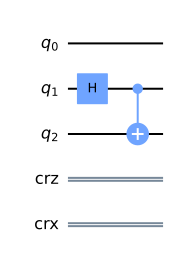

In [4]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

以下では、アリスは $q_1$、ボブは $q_2$ を持っているとしましょう。

#### ステップ 2 

アリスは、コントロール・ビットを $\vert\psi\rangle$ （彼女がボブに送ろうとしている量子ビット）として、$q_1$ に CNOT ゲートを作用させます。そして、$|\psi\rangle$ にアダマールゲートを作用させます。今回の量子回路では、アリスが送信しようとしている量子ビット（$|\psi\rangle$）は $q_0$ です：

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

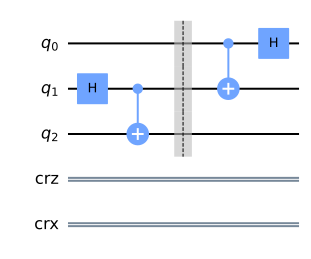

In [6]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

#### ステップ 3

次にアリスは、彼女が持っている両方の量子ビット $q_1$ と $\vert\psi\rangle$ を測定し、その結果を２つの古典ビットに格納します。これら２つのビットを、彼女はボブに送信します。

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

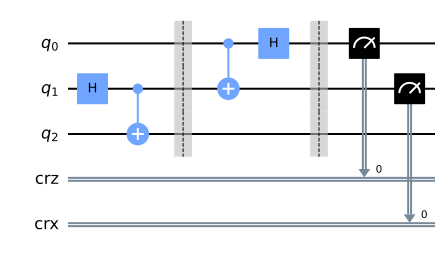

In [8]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

#### ステップ 4

既に $q_2$ を持っているボブは、送られてきた古典ビットの状態に従って $q_2$  に次のゲートを作用させます:

00 $\rightarrow$ 何もしません

01 $\rightarrow$ $X$ ゲートを適用

10 $\rightarrow$ $Z$ ゲートを適用

11 $\rightarrow$ $ZX$ ゲートを適用

（*注：情報の伝達は純粋に古典的な方法で行われます。* ）

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

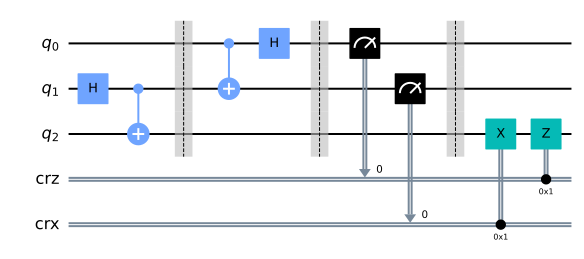

In [10]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

できました！プロトコルの最後に、アリスの量子ビットはボブにテレポートされます。

## 3. テレポーテーション・プロトコルのシミュレーショ <a id='simulating'></a>

### 3.1 量子コンピューターにおけるプロトコルの実験方法 <a id='testing'></a>

この notebook では、アリスの量子ビットをランダム状態 $\vert\psi\rangle$ （`psi`）で初期化します。この状態は`Initialize`（初期化）ゲートを $|q_0\rangle$ に作用させる事で作られます。この章では`psi`を選ぶために`random_state`関数を使いますが、`psi`を任意の量子ビット状態に設定してもかまいません。

<IPython.core.display.Math object>

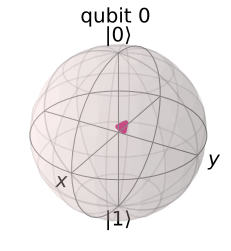

In [11]:
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

$|0\rangle$ から $|\psi\rangle$ を作る初期化ゲートを作りましょう：

In [12]:
init_gate = Initialize(psi)
init_gate.label = "init"

（`Initialize`にはリセット操作が含まれているため、技術的にはゲートではなく、元に戻すことはできません。代わりに「命令」と呼びます。）量子テレポーテーション回路が動作すれば、回路の最後に量子ビット $|q_2\rangle$ を状態がこの状態になるはずです。状態ベクトル・シミュレーターを使ってこれをチェックしてみましょう。

### 3.2 状態ベクトル・シミュレーターを使った方法 <a id='simulating-sv'></a>

状態ベクトル・シミュレーターを使うと、量子ビットがテレポートされたかどうかを確かめることができます。

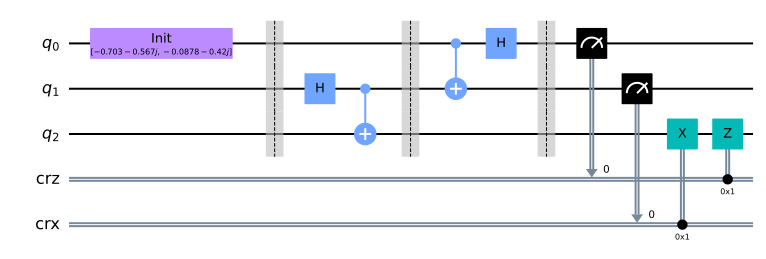

In [13]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

以下でみるように、この状態ベクトル・シミュレーターを用いると、状態$|q_2\rangle$ は上で作った状態 $|\psi\rangle$ と同じですが、状態 $|q_0\rangle$ と $|q_1\rangle$ は、状態 $|0\rangle$ か $|1\rangle$ のどちらかに崩れている事がわかります。状態 $|\psi\rangle$ は 量子ビット 0 から 2 にテレポートされています。

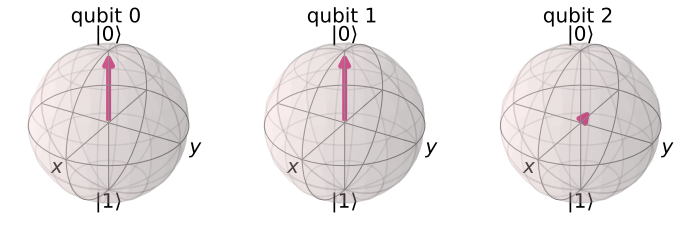

In [14]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

このセルを何回か実行してみてください。すると、量子ビット 0 と 1 の状態が変化している事に気づくと思いますが、量子ビット 2 は常に状態 $|\psi\rangle$ のままです。

### 3.3 QASM シミュレーターを使った方法 <a id='simulating-qs'></a>

量子テレポーテーションは２つのグループ間で量子ビットを送るようにデザインされています。これを実証するハードウェアを私たちは持ち合わせていませんが、単一の量子チップ上でなら、ゲートが正しい変換を行う事を実証することができます。ここでは、QASM シミュレーターを使用して、プロトコルをテストする方法をシミュレートします。

実際の量子コンピューターでは、状態ベクトルをサンプリングする事はできません。なので、テレポーテーション回路が稼働しているかをチェックしたければ手段を変える必要があります。みなさんは、量子ビット $|0\rangle$ を状態 $|\psi\rangle$ に変えるために初期化したことを覚えているでしょう：

$$ |0\rangle \xrightarrow{\text{初期化}} |\psi\rangle $$

全ての量子ゲートは可逆性を持っているので、次のようにして初期化の逆変換を得ることが出来ます：

In [15]:
inverse_init_gate = init_gate.gates_to_uncompute()

この演算子は次のような性質を持っています：

$$ |\psi\rangle \xrightarrow{\text{逆初期化}} |0\rangle $$

量子ビット $|q_0\rangle$ が $|q_2\rangle$ にテレポートした事を証明するには、$|q_2\rangle$ に対してこの逆初期化を行えば確実に $|0\rangle$ が測定できる事を期待すればよいのです。下の回路ではこれを実行しています：

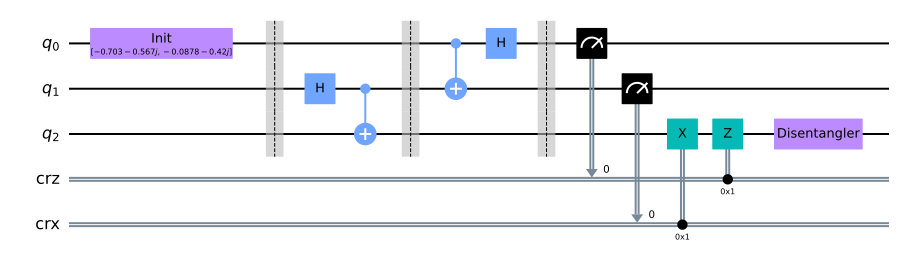

In [16]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

回路図では「disentangler」とラベルのついた、`inverse_init_gate`が表示されているのがわかります。最後に、３番目の古典ビットを測定して、その結果を古典ビットに確認します：

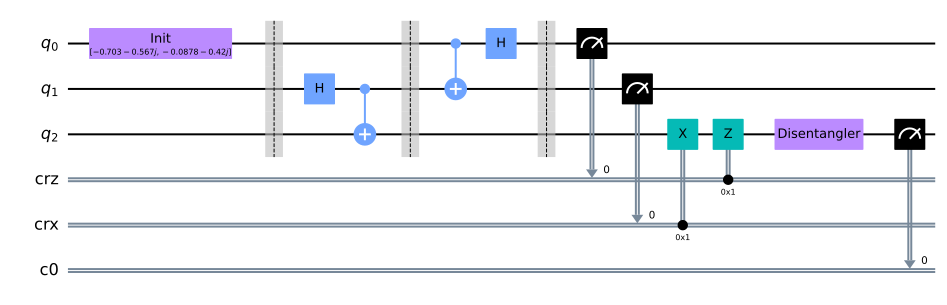

In [17]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

それでは実験を実行しましょう：

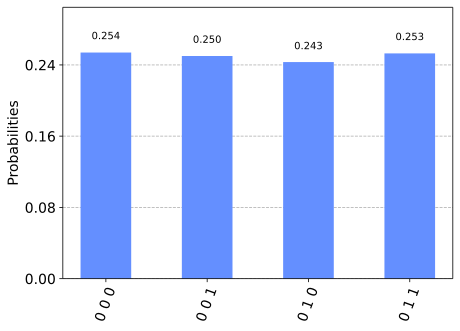

In [18]:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
plot_histogram(counts)

$q_2$ （文字列の左端のビット）の測定で 状態 $|0\rangle$ を得る確率が 100% であることがわかります。これは予想された結果であり、テレポーテーション・プロトコルが正常に動作した事を示しています。

## 4. 量子テレポーテーションを理解する <a id="understanding-qt">

量子テレポーテーションを実装したので、次にこのプロトコルの背景にある数学を理解しましょう。

#### ステップ 1

量子テレポーテーションは、アリスがボブに$|q\rangle = a|0\rangle + b|1\rangle$（ランダムな量子ビット）を送信する必要があるという事実から始まります。彼女は量子ビットの状態を知りません。このために、アリスとボブは第三者（テラモン）の助けを借ります。テラモンは、アリスとボブのためにエンタングルした量子ビットのペアを準備します。 エンタングルした量子ビットは、ディラック記法で次のように書くことができます：

$$ |\psi \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$

アリスとボブはそれぞれ、エンタングルした量子ビットのペアの1量子ビット（それぞれAとBとして示されます）ずつを持っています。

$$|\psi\rangle = \frac{1}{\sqrt{2}} (|0\rangle_A |0\rangle_B + |1\rangle_A |1\rangle_B) $$

この量子ビットのペアを使って、アリスが始めの2量子ビットを持ち、ボブが残りの1量子ビットを持つ、3量子ビット量子システムを作成します。

$$ \begin{align*}
|q\rangle \otimes |\psi\rangle &= \frac{1}{\sqrt{2}} (a |0\rangle \otimes (|00\rangle + |11\rangle) + b |1\rangle \otimes (|00\rangle + |11\rangle))\\
&= \frac{1}{\sqrt{2}} (a|000\rangle + a|011\rangle + b|100\rangle + b|111\rangle) 
\end{align*}$$

#### ステップ 2

プロトコルに従って、アリスは2つの量子ビットにCNOTゲートを適用し、続いて最初の量子ビットにアダマールゲートを適用します。 これにより、次の状態になります：

$$ 
\begin{align*} (H \otimes I \otimes I) (CNOT \otimes I) (|q\rangle \otimes |\psi\rangle)
&=(H \otimes I \otimes I) (CNOT \otimes I) \frac{1}{\sqrt{2}} (a|000\rangle + a|011\rangle + b|100\rangle + b|111\rangle) \\
&= (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (a|000\rangle + a|011\rangle + b|110\rangle + b|101\rangle) \\
&= \frac{1}{2}  (a(|000\rangle + |011\rangle + |100\rangle + |111\rangle) + b(|010\rangle + |001\rangle - |110\rangle - |101\rangle)) \\
\end{align*}
$$

次に、これを分離して次のように書くことができます：

$$
\begin{align*}
= \frac{1}{2}(
 & \phantom{+} |00\rangle (a|0\rangle + b|1\rangle) \hphantom{\quad )} \\
 & + |01\rangle (a|1\rangle + b|0\rangle) \hphantom{\quad )}\\[4pt]
 & + |10\rangle (a|0\rangle - b|1\rangle) \hphantom{\quad )}\\[4pt]
 & + |11\rangle (a|1\rangle - b|0\rangle) \quad )\\
\end{align*}
$$

#### ステップ 3

アリスは（彼女が所有している）最初の2量子ビットを測定し、それらを2つの古典ビットとしてボブに送信します。彼女が取得する結果は、常に4つの標準基底状態$|00\rangle, |01\rangle, |10\rangle, |11\rangle$のいずれかであり、確率は同じです。

彼女の測定に基づいて、ボブの状態は次のように予測されます。
$$ |00\rangle \rightarrow (a|0\rangle + b|1\rangle)\\
|01\rangle \rightarrow (a|1\rangle + b|0\rangle)\\
|10\rangle \rightarrow (a|0\rangle - b|1\rangle)\\
|11\rangle \rightarrow (a|1\rangle - b|0\rangle)$$.

#### ステップ 4

ボブは、アリスからビットを受け取ると、かつてエンタングルされたペアの一部であった量子ビットに適切な変換を適用することで、元の状態$|q\rangle$を取得できることを知っています。

彼が適用する必要のある変換は次のとおりです：

![title](images/teleportation-transformation.png)

このステップの後、ボブはアリスの状態を正しく再構築することができます。

## 5. 実際の量子コンピューターにおけるテレポーテーション <a id='real_qc'></a>

### 5.1 IBMハードウェアと遅延測定 <a id='deferred-measurement'></a>

IBMの量子コンピュータは現在、測定の後に行う命令系をサポートしていないため、実際のハードウェア上ではこれまでの形の回路による量子テレポーテーションを実行できません。ただ幸いなことに、[1]の4.4で説明されている「遅延測定原理」のおかげで、計算実行能力を制限することはありません。この原理は、どのような測定も回路の終端まで延期することができるというものです。つまりすべての測定を最後に持ってくる事が可能で、そこで測定しても同じ結果が得られるはずなのです。

![deferred_measurement_gates](images/defer_measurement.svg)

早い段階で測定を行うことで得られるメリットは、ハードウェアと関連しています。早期に測定できれば、量子ビットを再利用できるかもしれませんし、量子ビットが壊れやすい重ね合わせ状態にある時間を短縮できるかもしれません。この例では、量子テレポーテーションにおける早期測定が、直接量子通信チャンネルを使わず量子ビットの状態を送信出来たはずです。

ゲートを動かすことで実際のハードウェア上で「テレポーテーション」回路を実証することができる一方で、テレポーテーションプロセス（古典的なチャネルを介した量子状態の転送）の恩恵が失われていることに注意してください。

それでは、`bob_gates`関数を`new_bob_gates`に書き直してみましょう：

In [19]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

そして新しい回路を作ります：

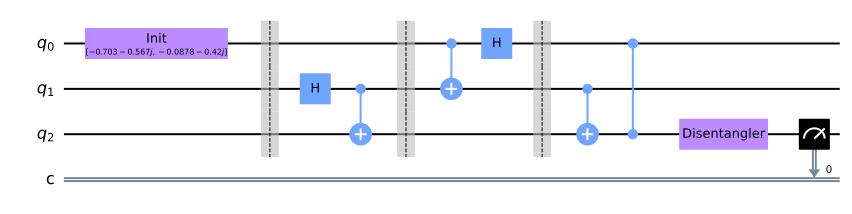

In [20]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

### 5.2 実行 <a id='executing'></a> 

In [21]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/usr/local/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [22]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  # displays job status under cell

Job Status: job has successfully run
{'0': 7528, '1': 664}


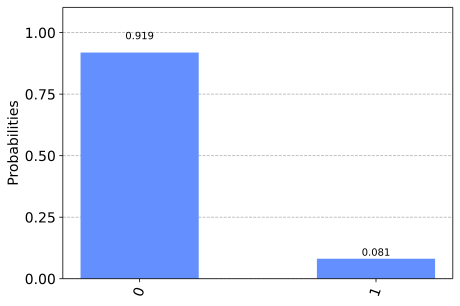

In [23]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

このように、$|1\rangle$ の測定結果は複数あります。これらはゲートと量子ビットのエラーに起因したものです。対照的に、この notebook のはじめに使ったシミュレーターではゲートのエラーはゼロであり、エラーのないテレポーテーションが可能でした。

In [24]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")

The experimental error rate :  8.10546875 %


## 6. 参考文献 <a id='references'></a>
[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[2] Eleanor Rieffel and Wolfgang Polak, Quantum Computing: a Gentle Introduction (The MIT Press Cambridge England, Massachusetts, 2011).

In [25]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit-terra': '0.16.0',
 'qiskit-aer': '0.7.0',
 'qiskit-ignis': '0.5.0',
 'qiskit-ibmq-provider': '0.11.0',
 'qiskit-aqua': '0.8.0',
 'qiskit': '0.23.0'}